In [12]:
import sys
import pandas as pd
import numpy as np
from pymatch.Matcher import Matcher
from IPython.display import Latex

# Table of Content
1. **Intuition behind what we do**
2. **Installation and technical aspects**
3. **Matching itself**
4. **Next steps**

## 1. Intuition behind what we do

This is one of the few examples that we have, and it solely focuses on the procedure of matching. We expect to post other workbooks soon.  

Let's refresh why you want to do matching at all.  


Imagine that you have nonrandomized data (i.e. you didn't run a randomized control trial, a.k.a. an A/B test, to collect it; most likely, it's just a Zeta data pool). The problem here is that you can't easily compare two groups from this data to each other due to the existing effect of confounding variables. One of the tricky portions here is that these confounding variables might be in your dataset and/or they might be outside of the dataset. In the latter case, there is not much you can do (actually, you can do at least one thing that we'll cover in the next workbook). In the former case, matching can alleviate some of your pains.  

If you have two groups you want to compare to each other (*one group had sessions and made purchases in the last seven days, another group had sessions and didn't make purchases in the last seven days*), you need to take users from one group and find a "twin" in another group. Twins are similar, and there has to be some measure of similarity. One of the most common (and intuitive) scores is a propensity score.  
Propensity scores are calculated using linear probability, logit or probit models. Differences among these three are subtle (*a logistic regression uses a logit link function, a probit regression uses an inverse normal link function, your plain vanilla linear probability model doesn't have a link function at all*) and are not really important for this discussion. Let's just agree to use a logit approach because below we will be comparing an binary treatment.  
The concept of the propensity score is not that hard to grasp. It is the conditional probability of being assigned to a particular treatment given a vector of observed covariates.

\begin{align}
e(x_i) = Pr(z_i = 1|x_i)
\end{align}

and

\begin{align}
Pr(z_1,...z_n|x_1,...x_n) = \sum_{i=1}^{n} e^{z_i} * (1-e(x_i)^{1-z_i}
\end{align}

where

\begin{align}
z_i = 1 \textrm{ for treatment}\\
z_i = 0 \textrm{ for control}\\
x_i \textrm{ is  the  vector  of  observed  covariates  for  the  } i_{th} \textrm{ subject}
\end{align}

If it looks to you as a likelihood of a binomial distribution, you're absolutely right.

If you calculated the propensity score in an A/B test, comparing two groups, then the score for each participant would be 0.5. This is because in a randomized test, each observation is assigned to a group with equal probabilities.  
So the the steps that any matching program is doing are:
1. calculate the probabilities of being assigned to a group. Let's say, you encode users without purchases as zero in a column "Test_Control" and users with purchases as one. It becomes your dependent variable that you want to predict using other columns as features. Sounds like a normal ML task, right?
2. separate this big datasets into two groups: one group was exposed to your treatment (in the example below, we're exploring whether making a saved search impacts your future purchases), another was not
3. take a user from one group and find a user from another group that has a very similar propensity score (calculated in step 1 above). How similar? It's controlled by the threshold, and you can alter it

Last but not least: **don't forget what you're trying to achieve.** I think that in our domain we're usually going after a marginal contribution (or impact) of some feature on some metric (GMB or one of its proxies). Matching on its own doesn't do this; all it does is prepare your (new) dataset. It means that after matching you'll need to take some other steps. What are these steps? We cannot know in advance. Usually many practitioners calculate Average Treatment Effect (ATE) or Average Treatment Effect on the Treated (ATT). Most of the tools allow to do it immediately after matching. However, it's not what we (probably) want. That said, we can put the procedure of matching somewhere in the middle of your workflow:  
Understanding of the problem --> Data Collection --> Reasoning about matching --> **Procedure of matching** --> Further analysis of the matched dataset.  
Maybe we can use an anology from machine learning: when you use some distance-based algorithm, you center (sometimes it's called "normalize") your numerical variables around a mean of zero with standard deviation of one (z-score). Does it tell you anything about the underlying problem? No. Is it required if you want to achieve better performance? Yes.  
That being said, this workbook merely describes only one step (from A to Z, though) and doesn't provide you a way to arrive to the final answer.

## Installation and technical aspects

The truth is that R has a more developed causal inference ecosystem. They're easy to use and can do anything you want in will return results in a format that you want. However, it this tutorial we decided to use exclusively Python because it's more aligned with the company's practices and preferences of most employees. Tools in Python are either basic and not supported by their creators, or super sophisticated and complex (you really need to know what you want to achieve and why you do it in a certain way). However, we found one package that does its job well, is relatively straightforward (and you can even dig into its code if you're interested in the topic and understand what it does exactly).  
The package is called **Pymatch.**  
Usually a traditional `pip install pymatch` will do.  
However, sometimes it won't install. Then you need another version: `pip install git+https://github.com/mc51/pymatch.git`.  
If you're in Krylov or for some other reason don't have access to the terminal, you can potentially install directly from inside your GUI:  
`!{sys.executable} -m pip install pymatch`  
or  
`!{sys.executable} -m pip install git+https://github.com/mc51/pymatch.git` respectively (Don't forget to `import sys` first).  

Finally, it sometimes fails to estimate the effect of matching on continious variables by throwing an error instead. We've found a way to correct it.  
1. Find where your Pymatch is installed by running `pip show pymatch` (or `!{sys.executable} -m pip show pymatch`)
2. Go there and find the folder with Pymatch. It will contain a few files but you need *Matcher.py*
3. Open it in your GUI of choice and search for `if uf.is_continuous(col, self.X) and col not in self.exclude`. It will be in the function `compare_continious`
4. You need to edit a few lines so that a chunk of code around looks like this:

In [ ]:
 test_results = []
    for col in self.matched_data.columns:
        is_continious = (col in self.X.columns) or ("Q('{}')".format(col) in self.X.columns)  # TYPE THIS LINE MANUALLY
        if is_continious and (not(col in self.exclude)):  # MAKE SURE EVERYTHING LOOKS LIKE HERE
        # if uf.is_continuous(col, self.X) and col not in self.exclude:  # COMMENT OR REMOVE THIS LINE
            # organize data
            trb, cob = self.test[col], self.control[col]
            tra = self.matched_data[self.matched_data[self.yvar]==True][col]
            coa = self.matched_data[self.matched_data[self.yvar]==False][col]
            xtb, xcb = ECDF(trb), ECDF(cob)
            xta, xca = ECDF(tra),ECDF(coa)

5. Save the file, go back to your GUI and restart the kernel.

## 3. Matching itself

We will use the same dataset as we used in the Analytics Talk presentation.

In [13]:
data = pd.read_csv('path to file')  # C:/Users/mkareev/Desktop/Engagement Actions/9_14_events_bin.csv

Columns' name should be self-explanatory:

In [14]:
data.columns.to_list()

['trans_cnt_p12m',
 'trans_day_cnt_p12m',
 'bought_item_cnt_p12m',
 'gmb_usd_amt_p12m',
 'days_since_last_trans',
 'tot_sess_cnt_l12m',
 'tot_sess_days_l12m',
 'tot_session_length_l12m',
 'apps_sess_share_l12m',
 'mweb_sess_share_l12m',
 'dweb_sess_share_l12m',
 'organic_sess_share_l12m',
 'free_sess_share_l12m',
 'paid_sess_share_l12m',
 'gmb_usd_amt_n3m',
 'num_ATC_events',
 'num_WATCH_events',
 'num_OFFER_events',
 'num_ASQ_events',
 'num_BID_events',
 'num_BIN_events',
 'gmb_usd_amt_n3m_binary',
 'num_ATC_events_binary',
 'num_WATCH_events_binary',
 'num_OFFER_events_binary',
 'num_ASQ_events_binary',
 'num_BID_events_binary',
 'num_BIN_events_binary']

We're interested in how various BBOWAC events on day 0 affect future 90-day GMB. This is called a treatment.    
BBOWAC events live in respective columns *num_name_of_event_events*.  
We've also encoded them as binary variables (because a binary use case is easier to understand and carry out).  
The outcome variable is *gmb_usd_amt_n3m* (and *gmb_usd_amt_n3m_binary* respectively).

We initialize the `Matcher` object.

In [15]:
from pymatch.Matcher import Matcher

Then you need to separate your data into test and control 

In [16]:
data_short = data
test = data_short[data_short.gmb_usd_amt_n3m_binary == 1]
control = data_short[data_short.gmb_usd_amt_n3m_binary == 0]

Into your object, you pass `test`, `control` datasets, the outcome variable and an optional parameter `exclude` using which you can exclude features that you don't want to use in matching. Usually it's your judgement call regarding what variables to exclude made based on the business understanding (and maybe correlation analysis).

In [18]:
m = Matcher(test, control, yvar = "gmb_usd_amt_n3m_binary", exclude = ['tot_sess_cnt_l12m', 'tot_sess_days_l12m', 'tot_session_length_l12m', 'apps_sess_share_l12m',
 'mweb_sess_share_l12m', 'dweb_sess_share_l12m', 'organic_sess_share_l12m', 'free_sess_share_l12m', 'paid_sess_share_l12m', 'gmb_usd_amt_n3m','num_ATC_events_binary', 'num_WATCH_events_binary', 'num_OFFER_events_binary',
 'num_ASQ_events_binary', 'num_BID_events_binary', 'num_BIN_events_binary'])

Formula:
gmb_usd_amt_n3m_binary ~ bought_item_cnt_p12m+days_since_last_trans+gmb_usd_amt_p12m+num_ASQ_events+num_ATC_events+num_BID_events+num_BIN_events+num_OFFER_events+num_WATCH_events+trans_cnt_p12m+trans_day_cnt_p12m
n majority: 77059
n minority: 16637


We see class imbalance: much more users with purchases than without. You can double check the results by running:

In [ ]:
len(data_short[data_short.gmb_usd_amt_n3m_binary == 1])  # 77059
len(data_short[data_short.gmb_usd_amt_n3m_binary == 0])   # 16637

It means that not every user with a purchase will find a twin among users without purchases. Unless you decide to match with replacement. This way, users from a smaller datasets will be used more than once. Another school of thought is to use a smaller dataset (no purchases in our case) as a base. As always, there is no agreement in the causal inference community on what is better. We will sample from a larger group below.

In [21]:
np.random.seed(22)
m.fit_scores(balance = True, nmodels = 100)

Static column dropped: gmb_usd_amt_n3m100

C:\Users\mkareev\Anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\mkareev\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: invalid value encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\mkareev\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:894: RuntimeWarning: divide by zero encountered in true_divide
  n_endog_mu = self._clean((1. - endog) / (1. - mu))
C:\Users\mkareev\Anaconda3\lib\site-packages\statsmodels\genmod\families\links.py:188: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
C:\Users\mkareev\Anaconda3\lib\site-packages\statsmodels\genmod\families\family.py:893: RuntimeWarning: divide by zero encountere

Static column dropped: gmb_usd_amt_n3m0\100
Average Accuracy: 74.02%


The accuracy above 50% suggests that separability between test and control sets indeed exists.

In [23]:
m.predict_scores()

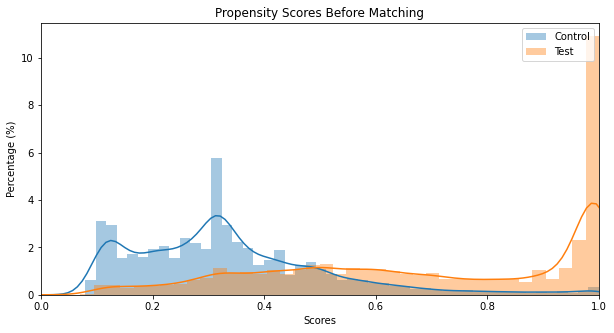

In [24]:
m.plot_scores()

In [ ]:
# matching w/ replacement. We can argue whether it depends on a problem (a business scenario) but I don't have much to say here yet
m.match(method = "min", nmatches = 1, threshold = 0.0001)  # min searches for the closest match, random takes the first match as long as its under the threshold
m.record_frequency()

In [ ]:
m.record_frequency()['n_records']

In [ ]:
m.matched_data.sort_values("match_id").head(6)

In [ ]:
# here is a twin pair
m.matched_data[(m.matched_data['match_id'] == 10133) & (m.matched_data['gmb_usd_amt_n3m_binary'] == 1)]
m.matched_data[(m.matched_data['match_id'] == 10133) & (m.matched_data['gmb_usd_amt_n3m_binary'] == 0)]